In [1]:
# Full script with corrected bounds/center/index block
# Requires: geopandas, shapely, networkx, numpy, matplotlib, fiona, pyproj, pandas
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import box
import matplotlib.pyplot as plt
import os
import pandas as pd

<Figure size 1200x1000 with 0 Axes>

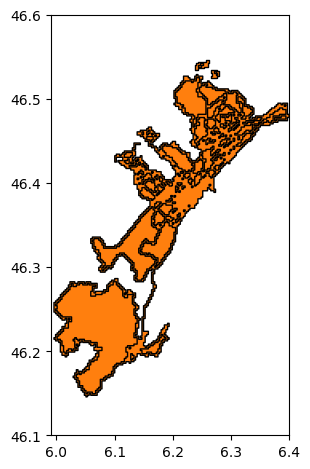

In [16]:

INPUT_KML = "squadrats-2025-11-03.kml"   # replace or point to uploaded file
OUT_DIR = "yardinho_output"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) load file (try KML driver; GeoPandas can usually read KML/KMZ)
gdf = gpd.read_file(INPUT_KML, driver="KML")
gdf_inho = gdf[(gdf['Name'] == 'squadratinhos')]

fig = plt.figure(figsize=(12,10))
gdf_inho.plot(color='tab:orange', edgecolor='k')
plt.xlim([5.99, 6.4])
plt.ylim([46.1, 46.6])
plt.tight_layout()
plt.show()





Loaded 218 polygons from KML file


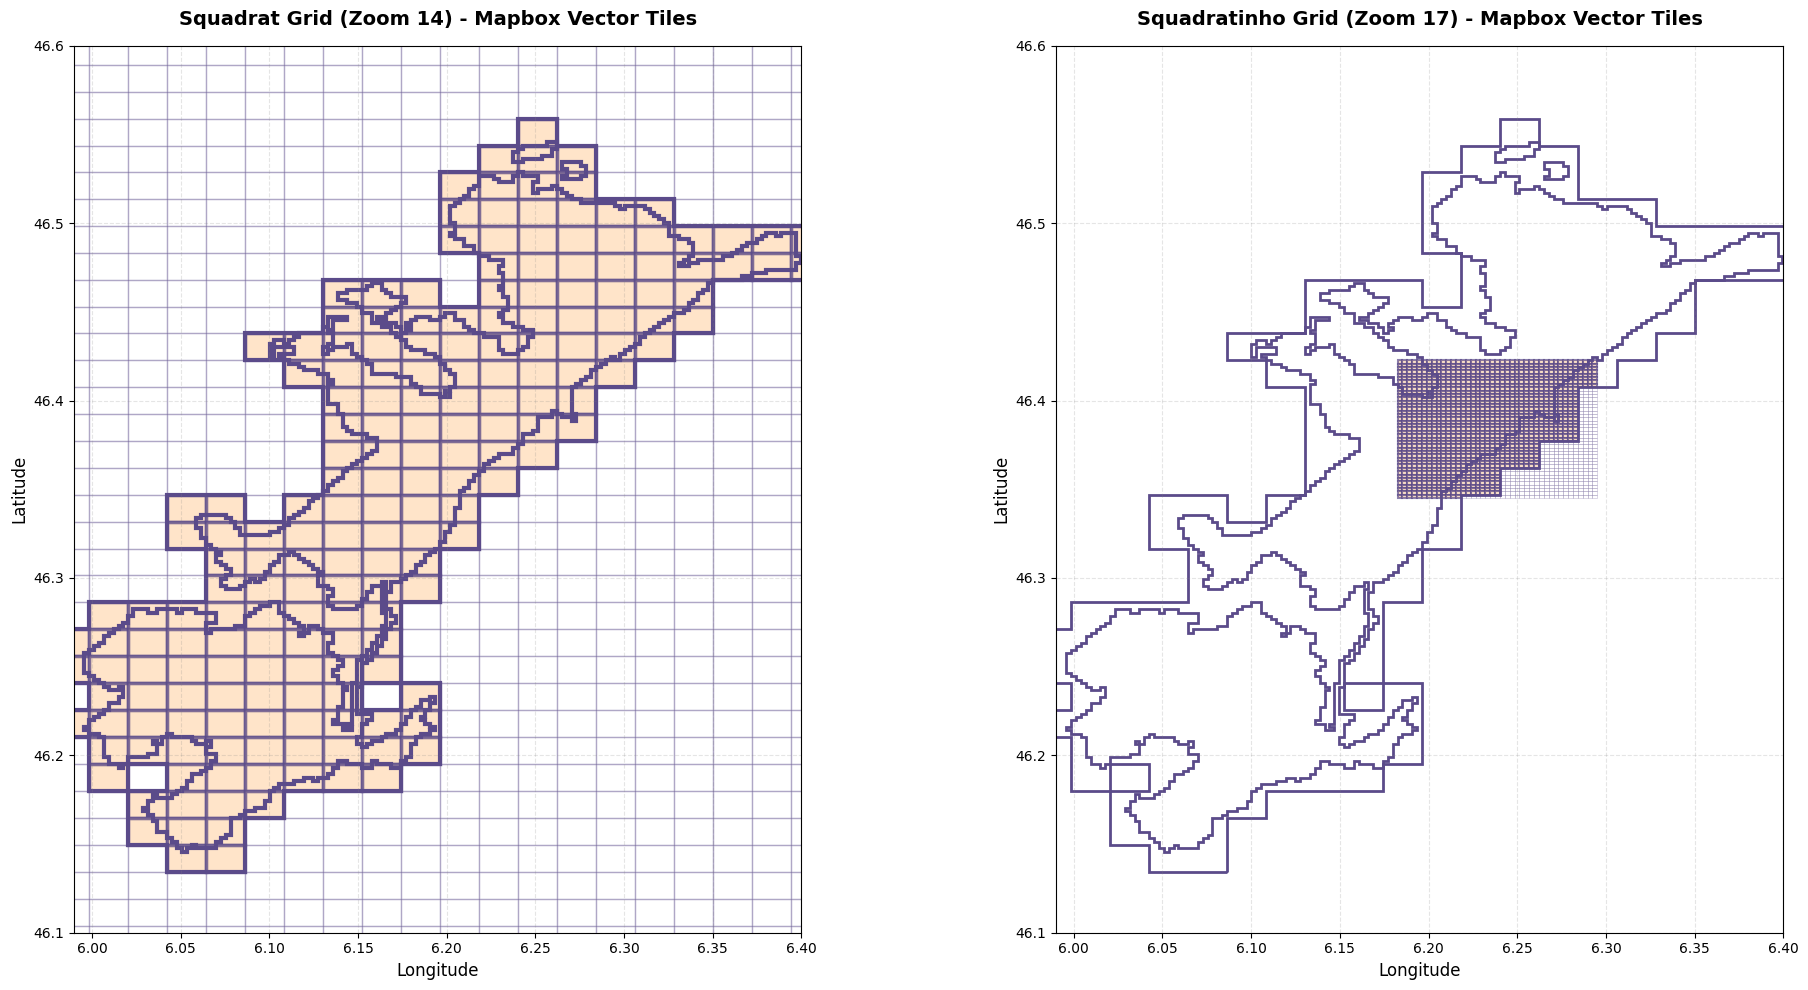

Saved grid mask to squadrat_grid_mask.csv
Saved grid mask to squadratinho_grid_mask.csv

Squadrat Grid (Zoom 14):
  Total tiles: 1681
  Tiles inside polygon: 206
  Tiles outside polygon: 1475
  Coverage: 12.3%

Squadratinho Grid (Zoom 17):
  Total tiles: 1681
  Tiles inside polygon: 1333
  Tiles outside polygon: 348
  Coverage: 79.3%


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from xml.etree import ElementTree as ET
from matplotlib.patches import Polygon
from matplotlib.path import Path
import csv

def latlon_to_tile(lat, lon, zoom):
    """Convert lat/lon to tile coordinates at given zoom level"""
    lat_rad = np.radians(lat)
    n = 2.0 ** zoom
    xtile = int((lon + 180.0) / 360.0 * n)
    ytile = int((1.0 - np.arcsinh(np.tan(lat_rad)) / np.pi) / 2.0 * n)
    return xtile, ytile

def tile_to_latlon(x, y, zoom):
    """Convert tile coordinates to lat/lon (northwest corner)"""
    n = 2.0 ** zoom
    lon = x / n * 360.0 - 180.0
    lat_rad = np.arctan(np.sinh(np.pi * (1 - 2 * y / n)))
    lat = np.degrees(lat_rad)
    return lat, lon

def get_tile_bounds(x, y, zoom):
    """Get the lat/lon bounds of a tile"""
    lat_nw, lon_nw = tile_to_latlon(x, y, zoom)
    lat_se, lon_se = tile_to_latlon(x + 1, y + 1, zoom)
    return lon_nw, lon_se, lat_se, lat_nw  # west, east, south, north

def parse_kml_coordinates(coord_string):
    """Parse KML coordinate string into list of (lon, lat) tuples"""
    coords = []
    coord_string = coord_string.strip()
    for coord in coord_string.split():
        parts = coord.split(',')
        if len(parts) >= 2:
            lon, lat = float(parts[0]), float(parts[1])
            coords.append((lon, lat))
    return coords

def load_kml_multipolygons(kml_file):
    """Load multipolygons from KML file"""
    tree = ET.parse(kml_file)
    root = tree.getroot()
    
    polygons = []
    
    # Find all Polygon elements
    for elem in root.iter():
        if 'Polygon' in elem.tag or elem.tag.endswith('Polygon'):
            # Look for coordinates in outerBoundaryIs or coordinates
            coords_elem = None
            for child in elem.iter():
                if 'coordinates' in child.tag:
                    coords_elem = child
                    break
            
            if coords_elem is not None and coords_elem.text:
                coords = parse_kml_coordinates(coords_elem.text)
                if len(coords) > 0:
                    polygons.append(coords)
    
    return polygons

def point_in_polygons(lon, lat, polygons):
    """Check if a point is inside any of the polygons"""
    point = (lon, lat)
    for poly_coords in polygons:
        path = Path(poly_coords)
        if path.contains_point(point):
            return True
    return False

def create_grid_mask(tiles, polygons):
    """Create binary mask: 1 if tile center is inside polygons, 0 otherwise"""
    mask = []
    for tile in tiles:
        x, y, west, east, south, north = tile
        center_lon = (west + east) / 2
        center_lat = (south + north) / 2
        inside = 1 if point_in_polygons(center_lon, center_lat, polygons) else 0
        mask.append((x, y, inside))
    return mask

def save_grid_mask_csv(mask, zoom, filename):
    """Save grid mask to CSV file"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['tile_x', 'tile_y', 'zoom', 'inside_polygon'])
        for x, y, inside in mask:
            writer.writerow([x, y, zoom, inside])
    print(f"Saved grid mask to {filename}")

def create_mapbox_grids_with_kml(center_lat, center_lon, kml_file=None,
                                  zoom_squadrat=14, zoom_squadratinho=17, 
                                  tiles_radius=10, figsize=(20, 10)):
    """
    Create squadrat (zoom 14) and squadratinho (zoom 17) grids with KML overlay
    
    Parameters:
    - center_lat, center_lon: Center point of the map
    - kml_file: Path to KML file with multipolygons (optional)
    - zoom_squadrat: Zoom level for squadrat grid (default 14)
    - zoom_squadratinho: Zoom level for squadratinho grid (default 17)
    - tiles_radius: Number of tiles to show in each direction from center
    - figsize: Figure size for matplotlib
    """
    
    # Load KML polygons if provided
    kml_polygons = []
    if kml_file:
        try:
            kml_polygons = load_kml_multipolygons(kml_file)
            print(f"Loaded {len(kml_polygons)} polygons from KML file")
        except Exception as e:
            print(f"Error loading KML file: {e}")
    
    # Get center tile coordinates
    center_x_sq, center_y_sq = latlon_to_tile(center_lat, center_lon, zoom_squadrat)
    center_x_sqinho, center_y_sqinho = latlon_to_tile(center_lat, center_lon, zoom_squadratinho)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # --- SQUADRAT GRID (Zoom 14) ---
    ax1.set_title(f'Squadrat Grid (Zoom {zoom_squadrat}) - Mapbox Vector Tiles', 
                  fontsize=14, fontweight='bold', pad=15)
    
    squadrat_tiles = []
    for dx in range(-tiles_radius, tiles_radius + 1):
        for dy in range(-tiles_radius, tiles_radius + 1):
            x = center_x_sq + dx
            y = center_y_sq + dy
            
            west, east, south, north = get_tile_bounds(x, y, zoom_squadrat)
            center_lon_tile = (west + east) / 2
            center_lat_tile = (south + north) / 2
            
            # Check if tile center is inside polygons
            inside = point_in_polygons(center_lon_tile, center_lat_tile, kml_polygons) if kml_polygons else False
            
            # Color based on whether inside polygon
            if inside:
                facecolor = '#FFD9B3'  # Light orange (peach)
                edgecolor = '#5B4B8A'  # Purple border
                alpha = 0.7
                linewidth = 2.5
            else:
                facecolor = 'white'
                edgecolor = '#5B4B8A'  # Purple border
                alpha = 0.3
                linewidth = 1.0
            
            # Create rectangle
            rect = patches.Rectangle((west, south), east - west, north - south,
                                     linewidth=linewidth, edgecolor=edgecolor, 
                                     facecolor=facecolor, alpha=alpha)
            ax1.add_patch(rect)
            
            squadrat_tiles.append((x, y, west, east, south, north))
    
    # Overlay KML polygon borders on top
    if kml_polygons:
        for poly_coords in kml_polygons:
            xy = [(lon, lat) for lon, lat in poly_coords]
            poly = Polygon(xy, linewidth=3, edgecolor='#5B4B8A', 
                          facecolor='none', alpha=1.0)
            ax1.add_patch(poly)
    
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.grid(True, alpha=0.2, linestyle='--', color='gray')
    ax1.set_aspect('equal', adjustable='box')
    
    # --- SQUADRATINHO GRID (Zoom 17) ---
    ax2.set_title(f'Squadratinho Grid (Zoom {zoom_squadratinho}) - Mapbox Vector Tiles', 
                  fontsize=14, fontweight='bold', pad=15)
    
    squadratinho_tiles = []
    for dx in range(-tiles_radius, tiles_radius + 1):
        for dy in range(-tiles_radius, tiles_radius + 1):
            x = center_x_sqinho + dx
            y = center_y_sqinho + dy
            
            west, east, south, north = get_tile_bounds(x, y, zoom_squadratinho)
            center_lon_tile = (west + east) / 2
            center_lat_tile = (south + north) / 2
            
            # Check if tile center is inside polygons
            inside = point_in_polygons(center_lon_tile, center_lat_tile, kml_polygons) if kml_polygons else False
            
            # Color based on whether inside polygon
            if inside:
                facecolor = '#FFD9B3'  # Light orange (peach)
                edgecolor = '#5B4B8A'  # Purple border
                alpha = 0.7
                linewidth = 1.5
            else:
                facecolor = 'white'
                edgecolor = '#5B4B8A'  # Purple border
                alpha = 0.3
                linewidth = 0.5
            
            # Create rectangle
            rect = patches.Rectangle((west, south), east - west, north - south,
                                     linewidth=linewidth, edgecolor=edgecolor, 
                                     facecolor=facecolor, alpha=alpha)
            ax2.add_patch(rect)
            
            squadratinho_tiles.append((x, y, west, east, south, north))
    
    # Overlay KML polygon borders on top
    if kml_polygons:
        for poly_coords in kml_polygons:
            xy = [(lon, lat) for lon, lat in poly_coords]
            poly = Polygon(xy, linewidth=2, edgecolor='#5B4B8A', 
                          facecolor='none', alpha=1.0)
            ax2.add_patch(poly)
    
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.set_ylabel('Latitude', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='--', color='gray')
    ax2.set_aspect('equal', adjustable='box')
    
    for ax in [ax1, ax2]:
        ax.set_xlim([5.99, 6.4])
        ax.set_ylim([46.1, 46.6])
    plt.tight_layout()
    plt.show()
    
    # Create and save grid masks
    if kml_polygons:
        squadrat_mask = create_grid_mask(squadrat_tiles, kml_polygons)
        squadratinho_mask = create_grid_mask(squadratinho_tiles, kml_polygons)
        
        save_grid_mask_csv(squadrat_mask, zoom_squadrat, 'squadrat_grid_mask.csv')
        save_grid_mask_csv(squadratinho_mask, zoom_squadratinho, 'squadratinho_grid_mask.csv')
        
        # Statistics
        squadrat_inside = sum(1 for _, _, inside in squadrat_mask if inside == 1)
        squadratinho_inside = sum(1 for _, _, inside in squadratinho_mask if inside == 1)
        
        print(f"\nSquadrat Grid (Zoom {zoom_squadrat}):")
        print(f"  Total tiles: {len(squadrat_tiles)}")
        print(f"  Tiles inside polygon: {squadrat_inside}")
        print(f"  Tiles outside polygon: {len(squadrat_tiles) - squadrat_inside}")
        print(f"  Coverage: {squadrat_inside/len(squadrat_tiles)*100:.1f}%")
        
        print(f"\nSquadratinho Grid (Zoom {zoom_squadratinho}):")
        print(f"  Total tiles: {len(squadratinho_tiles)}")
        print(f"  Tiles inside polygon: {squadratinho_inside}")
        print(f"  Tiles outside polygon: {len(squadratinho_tiles) - squadratinho_inside}")
        print(f"  Coverage: {squadratinho_inside/len(squadratinho_tiles)*100:.1f}%")
    
    return squadrat_tiles, squadratinho_tiles

# Centered on Nyon, Switzerland
center_lat = 46.3833  # Nyon latitude
center_lon = 6.2389   # Nyon longitude

# Specify your KML file path here
kml_file_path = 'squadrats-2025-11-03.kml'  # Replace with your actual KML file path

squadrat, squadratinho = create_mapbox_grids_with_kml(
    center_lat=center_lat,
    center_lon=center_lon,
    kml_file=kml_file_path,  # Set to None if no KML file
    zoom_squadrat=14,
    zoom_squadratinho=17,
    tiles_radius=20  # Show 21x21 grid of tiles
)